<a href="https://colab.research.google.com/github/sanjayyy-22/devnet-anomaly-detection/blob/main/Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%writefile utils.py
import os
import pandas as pd
import numpy as np
from sklearn.metrics import auc,roc_curve, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn import preprocessing
import matplotlib.pyplot as plt
from joblib import Memory
from sklearn.datasets import load_svmlight_file

mem = Memory("./dataset/svm_data")

@mem.cache
def get_data_from_svmlight_file(path):
    data = load_svmlight_file(path)
    return data[0], data[1]

def dataLoading(path):
    # loading data
    df = pd.read_csv(path)

    labels = df['class']

    x_df = df.drop(['class'], axis=1)

    x = x_df.values
    print("Data shape: (%d, %d)" % x.shape)

    return x, labels;


def aucPerformance(mse, labels):
    roc_auc = roc_auc_score(labels, mse)
    ap = average_precision_score(labels, mse)
    print("AUC-ROC: %.4f, AUC-PR: %.4f" % (roc_auc, ap))
    return roc_auc, ap;

def writeResults(name, n_samples, dim, n_samples_trn, n_outliers_trn, n_outliers, depth, rauc, ap, std_auc, std_ap, train_time, test_time, path = "./results/auc_performance_cl0.5.csv"):
    csv_file = open(path, 'a')
    row = name + "," + str(n_samples)+ ","  + str(dim) + ',' + str(n_samples_trn) + ','+ str(n_outliers_trn) + ','+ str(n_outliers)  + ',' + str(depth)+ "," + str(rauc) +"," + str(std_auc) + "," + str(ap) +"," + str(std_ap)+"," + str(train_time)+"," + str(test_time) + "\n"
    csv_file.write(row)


Overwriting utils.py


In [ ]:
# %%writefile devnet.py
# import numpy as np
# np.random.seed(42)
# import tensorflow as tf
# tf.random.set_seed(42)
# # sess = tf.Session()
# import os
# from keras import regularizers
# from keras import backend as K
# from keras.models import Model, load_model
# from keras.layers import Input, Dense
# from keras.optimizers import RMSprop
# from keras.callbacks import ModelCheckpoint, TensorBoard

# import argparse
# import numpy as np
# import matplotlib.pyplot as plt
# import sys
# from scipy.sparse import vstack, csc_matrix
# from utils import dataLoading, aucPerformance, writeResults, get_data_from_svmlight_file
# from sklearn.model_selection import train_test_split

# import time

# MAX_INT = np.iinfo(np.int32).max
# data_format = 0

# confidence_margin = 5.
# ref = tf.cast(tf.Variable(np.random.normal(loc=0., scale=1.0, size=5000)), dtype=tf.float32)


# def dev_network_d(input_shape):
#     '''
#     deeper network architecture with three hidden layers
#     '''
#     x_input = Input(shape=input_shape)
#     intermediate = Dense(1000, activation='relu',
#                 kernel_regularizer=regularizers.l2(0.01), name = 'hl1')(x_input)
#     intermediate = Dense(250, activation='relu',
#                 kernel_regularizer=regularizers.l2(0.01), name = 'hl2')(intermediate)
#     intermediate = Dense(20, activation='relu',
#                 kernel_regularizer=regularizers.l2(0.01), name = 'hl3')(intermediate)
#     intermediate = Dense(1, activation='linear', name = 'score')(intermediate)
#     return Model(x_input, intermediate)

# def dev_network_s(input_shape):
#     '''
#     network architecture with one hidden layer
#     '''
#     x_input = Input(shape=input_shape)
#     intermediate = Dense(20, activation='relu',
#                 kernel_regularizer=regularizers.l2(0.01), name = 'hl1')(x_input)
#     intermediate = Dense(1, activation='linear',  name = 'score')(intermediate)
#     return Model(x_input, intermediate)

# def dev_network_linear(input_shape):
#     '''
#     network architecture with no hidden layer, equivalent to linear mapping from
#     raw inputs to anomaly scores
#     '''
#     x_input = Input(shape=input_shape)
#     intermediate = Dense(1, activation='linear',  name = 'score')(x_input)
#     return Model(x_input, intermediate)

# def deviation_loss(y_true, y_pred):
#     '''
#     z-score-based deviation loss
#     '''
#     dev = (y_pred - tf.reduce_mean(ref)) / tf.math.reduce_std(ref) # Use tf.reduce_mean and tf.math.reduce_std instead of K.mean and K.std
#     inlier_loss = tf.abs(dev) # Use tf.abs instead of K.abs
#     outlier_loss = tf.abs(tf.maximum(confidence_margin - dev, 0.))  # Use tf.abs and tf.maximum instead of K.abs and K.maximum

#     return tf.reduce_mean((1 - y_true) * inlier_loss + y_true * outlier_loss) # Use tf.reduce_mean instead of K.mean


# def deviation_network(input_shape, network_depth):
#     '''
#     construct the deviation network-based detection model
#     '''
#     if network_depth == 4:
#         model = dev_network_d(input_shape)
#     elif network_depth == 2:
#         model = dev_network_s(input_shape)
#     elif network_depth == 1:
#         model = dev_network_linear(input_shape)
#     else:
#         sys.exit("The network depth is not set properly")
#     rms = RMSprop(clipnorm=1.)
#     model.compile(loss=deviation_loss, optimizer=rms)
#     return model


# def batch_generator_sup(x, outlier_indices, inlier_indices, batch_size, nb_batch, rng):
#     """batch generator
#     """
#     rng = np.random.RandomState(rng.randint(MAX_INT, size = 1))
#     counter = 0
#     while 1:
#         if data_format == 0:
#             ref, training_labels = input_batch_generation_sup(x, outlier_indices, inlier_indices, batch_size, rng)
#         else:
#             ref, training_labels = input_batch_generation_sup_sparse(x, outlier_indices, inlier_indices, batch_size, rng)
#         counter += 1
#         yield(ref, training_labels)
#         if (counter > nb_batch):
#             counter = 0

# def input_batch_generation_sup(x_train, outlier_indices, inlier_indices, batch_size, rng):
#     '''
#     batchs of samples. This is for csv data.
#     Alternates between positive and negative pairs.
#     '''
#     dim = x_train.shape[1]
#     ref = np.empty((batch_size, dim))
#     training_labels = []
#     n_inliers = len(inlier_indices)
#     n_outliers = len(outlier_indices)
#     for i in range(batch_size):
#         if(i % 2 == 0):
#             sid = rng.choice(n_inliers, 1)
#             ref[i] = x_train[inlier_indices[sid]]
#             training_labels += [0]
#         else:
#             sid = rng.choice(n_outliers, 1)
#             ref[i] = x_train[outlier_indices[sid]]
#             training_labels += [1]
#     return np.array(ref), np.array(training_labels)


# def input_batch_generation_sup_sparse(x_train, outlier_indices, inlier_indices, batch_size, rng):
#     '''
#     batchs of samples. This is for libsvm stored sparse data.
#     Alternates between positive and negative pairs.
#     '''
#     ref = np.empty((batch_size))
#     training_labels = []
#     n_inliers = len(inlier_indices)
#     n_outliers = len(outlier_indices)
#     for i in range(batch_size):
#         if(i % 2 == 0):
#             sid = rng.choice(n_inliers, 1)
#             ref[i] = inlier_indices[sid]
#             training_labels += [0]
#         else:
#             sid = rng.choice(n_outliers, 1)
#             ref[i] = outlier_indices[sid]
#             training_labels += [1]
#     ref = x_train[ref, :].toarray()
#     return ref, np.array(training_labels)


# def load_model_weight_predict(model_name, input_shape, network_depth, x_test):
#     '''
#     load the saved weights to make predictions
#     '''
#     model = deviation_network(input_shape, network_depth)
#     model.load_weights(model_name)
#     scoring_network = Model(inputs=model.input, outputs=model.output)

#     if data_format == 0:
#         scores = scoring_network.predict(x_test)
#     else:
#         data_size = x_test.shape[0]
#         scores = np.zeros([data_size, 1])
#         count = 512
#         i = 0
#         while i < data_size:
#             subset = x_test[i:count].toarray()
#             scores[i:count] = scoring_network.predict(subset)
#             if i % 1024 == 0:
#                 print(i)
#             i = count
#             count += 512
#             if count > data_size:
#                 count = data_size
#         assert count == data_size
#     return scores


# def inject_noise_sparse(seed, n_out, random_seed):
#     '''
#     add anomalies to training data to replicate anomaly contaminated data sets.
#     we randomly swape 5% features of anomalies to avoid duplicate contaminated anomalies.
#     This is for sparse data.
#     '''
#     rng = np.random.RandomState(random_seed)
#     n_sample, dim = seed.shape
#     swap_ratio = 0.05
#     n_swap_feat = int(swap_ratio * dim)
#     seed = seed.tocsc()
#     noise = csc_matrix((n_out, dim))
#     print(noise.shape)
#     for i in np.arange(n_out):
#         outlier_idx = rng.choice(n_sample, 2, replace = False)
#         o1 = seed[outlier_idx[0]]
#         o2 = seed[outlier_idx[1]]
#         swap_feats = rng.choice(dim, n_swap_feat, replace = False)
#         noise[i] = o1.copy()
#         noise[i, swap_feats] = o2[0, swap_feats]
#     return noise.tocsr()

# def inject_noise(seed, n_out, random_seed):
#     '''
#     add anomalies to training data to replicate anomaly contaminated data sets.
#     we randomly swape 5% features of anomalies to avoid duplicate contaminated anomalies.
#     this is for dense data
#     '''
#     rng = np.random.RandomState(random_seed)
#     n_sample, dim = seed.shape
#     swap_ratio = 0.05
#     n_swap_feat = int(swap_ratio * dim)
#     noise = np.empty((n_out, dim))
#     for i in np.arange(n_out):
#         outlier_idx = rng.choice(n_sample, 2, replace = False)
#         o1 = seed[outlier_idx[0]]
#         o2 = seed[outlier_idx[1]]
#         swap_feats = rng.choice(dim, n_swap_feat, replace = False)
#         noise[i] = o1.copy()
#         noise[i, swap_feats] = o2[swap_feats]
#     return noise

# def run_devnet(args):
#     names = args.data_set.split(',')
#     names = ['annthyroid_21feat_normalised']
#     network_depth = int(args.network_depth)
#     random_seed = args.ramdn_seed
#     for nm in names:
#         runs = args.runs
#         rauc = np.zeros(runs)
#         ap = np.zeros(runs)
#         filename = nm.strip()
#         global data_format
#         data_format = int(args.data_format)
#         if data_format == 0:
#             x, labels = dataLoading(args.input_path + filename + ".csv")
#         else:
#             x, labels = get_data_from_svmlight_file(args.input_path + filename + ".svm")
#             x = x.tocsr()
#         outlier_indices = np.where(labels == 1)[0]
#         outliers = x[outlier_indices]
#         n_outliers_org = outliers.shape[0]

#         train_time = 0
#         test_time = 0
#         for i in np.arange(runs):
#             x_train, x_test, y_train, y_test = train_test_split(x, labels, test_size=0.2, random_state=42, stratify = labels)
#             y_train = np.array(y_train)
#             y_test = np.array(y_test)
#             print(filename + ': round ' + str(i))
#             outlier_indices = np.where(y_train == 1)[0]
#             inlier_indices = np.where(y_train == 0)[0]
#             n_outliers = len(outlier_indices)
#             print("Original training size: %d, No. outliers: %d" % (x_train.shape[0], n_outliers))

#             n_noise  = len(np.where(y_train == 0)[0]) * args.cont_rate / (1. - args.cont_rate)
#             n_noise = int(n_noise)

#             rng = np.random.RandomState(random_seed)
#             if data_format == 0:
#                 if n_outliers > args.known_outliers:
#                     mn = n_outliers - args.known_outliers
#                     remove_idx = rng.choice(outlier_indices, mn, replace=False)
#                     x_train = np.delete(x_train, remove_idx, axis=0)
#                     y_train = np.delete(y_train, remove_idx, axis=0)

#                 noises = inject_noise(outliers, n_noise, random_seed)
#                 x_train = np.append(x_train, noises, axis = 0)
#                 y_train = np.append(y_train, np.zeros((noises.shape[0], 1)))

#             else:
#                 if n_outliers > args.known_outliers:
#                     mn = n_outliers - args.known_outliers
#                     remove_idx = rng.choice(outlier_indices, mn, replace=False)
#                     retain_idx = set(np.arange(x_train.shape[0])) - set(remove_idx)
#                     retain_idx = list(retain_idx)
#                     x_train = x_train[retain_idx]
#                     y_train = y_train[retain_idx]

#                 noises = inject_noise_sparse(outliers, n_noise, random_seed)
#                 x_train = vstack([x_train, noises])
#                 y_train = np.append(y_train, np.zeros((noises.shape[0], 1)))

#             outlier_indices = np.where(y_train == 1)[0]
#             inlier_indices = np.where(y_train == 0)[0]
#             print(y_train.shape[0], outlier_indices.shape[0], inlier_indices.shape[0], n_noise)
#             input_shape = x_train.shape[1:]
#             n_samples_trn = x_train.shape[0]
#             n_outliers = len(outlier_indices)
#             print("Training data size: %d, No. outliers: %d" % (x_train.shape[0], n_outliers))


#             start_time = time.time()
#             input_shape = x_train.shape[1:]
#             epochs = args.epochs
#             batch_size = args.batch_size
#             nb_batch = args.nb_batch
#             model = deviation_network(input_shape, network_depth)
#             print(model.summary())
#             model_name = "./model/devnet_"  + filename + "_" + str(args.cont_rate) + "cr_"  + str(args.batch_size) +"bs_" + str(args.known_outliers) + "ko_" + str(network_depth) +"d.weights.h5"
# #The file path provided to ModelCheckpoint needs to end in .weights.h5 when using save_weights_only=True
#             checkpointer = ModelCheckpoint(model_name, monitor='loss', verbose=0,
#                                            save_best_only = True, save_weights_only = True)

#             model.fit(batch_generator_sup(x_train, outlier_indices, inlier_indices, batch_size, nb_batch, rng),
#                                           steps_per_epoch = nb_batch,
#                                           epochs = epochs,
#                                           callbacks=[checkpointer])
#             train_time += time.time() - start_time

#             start_time = time.time()
#             scores = load_model_weight_predict(model_name, input_shape, network_depth, x_test)
#             test_time += time.time() - start_time
#             rauc[i], ap[i] = aucPerformance(scores, y_test)

#         mean_auc = np.mean(rauc)
#         std_auc = np.std(rauc)
#         mean_aucpr = np.mean(ap)
#         std_aucpr = np.std(ap)
#         train_time = train_time/runs
#         test_time = test_time/runs
#         print("average AUC-ROC: %.4f, average AUC-PR: %.4f" % (mean_auc, mean_aucpr))
#         print("average runtime: %.4f seconds" % (train_time + test_time))
#         writeResults(filename+'_'+str(network_depth), x.shape[0], x.shape[1], n_samples_trn, n_outliers_org, n_outliers,
#                      network_depth, mean_auc, mean_aucpr, std_auc, std_aucpr, train_time, test_time, path=args.output)
#         return mean_auc, mean_aucpr

# # def run_devnet(args):
# #     names = args.data_set.split(',')
# #     names = ['annthyroid_21feat_normalised']
# #     network_depth = int(args.network_depth)
# #     random_seed = args.ramdn_seed

# #     # For storing results across datasets
# #     all_results = []

# #     for nm in names:
# #         runs = args.runs
# #         rauc = np.zeros(runs)
# #         ap = np.zeros(runs)
# #         filename = nm.strip()
# #         global data_format
# #         data_format = int(args.data_format)
# #         if data_format == 0:
# #             x, labels = dataLoading(args.input_path + filename + ".csv")
# #         else:
# #             x, labels = get_data_from_svmlight_file(args.input_path + filename + ".svm")
# #             x = x.tocsr()
# #         outlier_indices = np.where(labels == 1)[0]
# #         outliers = x[outlier_indices]
# #         n_outliers_org = outliers.shape[0]

# #         train_time = 0
# #         test_time = 0

# #         # For storing visualization data
# #         dataset_info = {
# #             'name': filename,
# #             'scores': [],
# #             'true_labels': [],
# #             'x_test_data': [],
# #             'histories': []
# #         }

# #         for i in np.arange(runs):
# #             x_train, x_test, y_train, y_test = train_test_split(x, labels, test_size=0.2, random_state=42, stratify=labels)
# #             y_train = np.array(y_train)
# #             y_test = np.array(y_test)
# #             print(filename + ': round ' + str(i))
# #             outlier_indices = np.where(y_train == 1)[0]
# #             inlier_indices = np.where(y_train == 0)[0]
# #             n_outliers = len(outlier_indices)
# #             print("Original training size: %d, No. outliers: %d" % (x_train.shape[0], n_outliers))

# #             n_noise = len(np.where(y_train == 0)[0]) * args.cont_rate / (1. - args.cont_rate)
# #             n_noise = int(n_noise)

# #             rng = np.random.RandomState(random_seed)
# #             if data_format == 0:
# #                 if n_outliers > args.known_outliers:
# #                     mn = n_outliers - args.known_outliers
# #                     remove_idx = rng.choice(outlier_indices, mn, replace=False)
# #                     x_train = np.delete(x_train, remove_idx, axis=0)
# #                     y_train = np.delete(y_train, remove_idx, axis=0)

# #                 noises = inject_noise(outliers, n_noise, random_seed)
# #                 x_train = np.append(x_train, noises, axis=0)
# #                 y_train = np.append(y_train, np.zeros((noises.shape[0], 1)))

# #             else:
# #                 if n_outliers > args.known_outliers:
# #                     mn = n_outliers - args.known_outliers
# #                     remove_idx = rng.choice(outlier_indices, mn, replace=False)
# #                     retain_idx = set(np.arange(x_train.shape[0])) - set(remove_idx)
# #                     retain_idx = list(retain_idx)
# #                     x_train = x_train[retain_idx]
# #                     y_train = y_train[retain_idx]

# #                 noises = inject_noise_sparse(outliers, n_noise, random_seed)
# #                 x_train = vstack([x_train, noises])
# #                 y_train = np.append(y_train, np.zeros((noises.shape[0], 1))).reshape(-1)

# #             outlier_indices = np.where(y_train == 1)[0]
# #             inlier_indices = np.where(y_train == 0)[0]
# #             print(y_train.shape[0], outlier_indices.shape[0], inlier_indices.shape[0], n_noise)
# #             input_shape = x_train.shape[1:]
# #             n_samples_trn = x_train.shape[0]
# #             n_outliers = len(outlier_indices)
# #             print("Training data size: %d, No. outliers: %d" % (x_train.shape[0], n_outliers))

# #             start_time = time.time()
# #             input_shape = x_train.shape[1:]
# #             epochs = args.epochs
# #             batch_size = args.batch_size
# #             nb_batch = args.nb_batch
# #             model = deviation_network(input_shape, network_depth)
# #             print(model.summary())
# #             model_name = "./model/devnet_" + filename + "_" + str(args.cont_rate) + "cr_" + str(args.batch_size) + "bs_" + str(args.known_outliers) + "ko_" + str(network_depth) + "d.weights.h5"

# #             # Create a directory for visualizations
# #             os.makedirs('./visualizations', exist_ok=True)
# #             vis_prefix = f"./visualizations/{filename}_cr{args.cont_rate}_ko{args.known_outliers}_d{network_depth}_run{i}"

# #             # The file path provided to ModelCheckpoint needs to end in .weights.h5 when using save_weights_only=True
# #             checkpointer = ModelCheckpoint(model_name, monitor='loss', verbose=0,
# #                                           save_best_only=True, save_weights_only=True)

# #             # Modify to capture training history
# #             history = model.fit(
# #                 batch_generator_sup(x_train, outlier_indices, inlier_indices, batch_size, nb_batch, rng),
# #                 steps_per_epoch=nb_batch,
# #                 epochs=epochs,
# #                 callbacks=[checkpointer],
# #                 verbose=1
# #             )

# #             # Store history for visualization
# #             dataset_info['histories'].append(history)

# #             # Plot training history
# #             plot_training_history(
# #                 history,
# #                 title=f"DevNet Training History - {filename} (Run {i+1})",
# #                 save_path=f"{vis_prefix}_training_history.png"
# #             )

# #             train_time += time.time() - start_time

# #             start_time = time.time()
# #             scores = load_model_weight_predict(model_name, input_shape, network_depth, x_test)
# #             test_time += time.time() - start_time

# #             # Store scores and test data for visualization
# #             dataset_info['scores'].append(scores)
# #             dataset_info['true_labels'].append(y_test)
# #             dataset_info['x_test_data'].append(x_test)

# #             # Plot score distributions
# #             plot_score_distributions(
# #                 scores, y_test,
# #                 title=f"DevNet Score Distribution - {filename} (Run {i+1})",
# #                 save_path=f"{vis_prefix}_score_distribution.png"
# #             )

# #             # Plot ROC and PR curves
# #             current_auc_roc, current_auc_pr = plot_roc_pr_curves(
# #                 scores, y_test,
# #                 title_prefix=f"DevNet Performance - {filename} (Run {i+1})",
# #                 save_path=f"{vis_prefix}_roc_pr_curves.png"
# #             )

# #             # Visualize data with anomaly scores (limited to datasets with manageable dimensions)
# #             if x_test.shape[1] <= 100:  # Only for datasets with reasonable dimensionality
# #                 visualize_data_with_scores(
# #                     x_test, y_test, scores, method='tsne',
# #                     title_prefix=f"DevNet - {filename} (Run {i+1})",
# #                     save_path=f"{vis_prefix}_tsne_visualization.png"
# #                 )

# #             rauc[i], ap[i] = aucPerformance(scores, y_test)

# #         # Compute average performance
# #         mean_auc = np.mean(rauc)
# #         std_auc = np.std(rauc)
# #         mean_aucpr = np.mean(ap)
# #         std_aucpr = np.std(ap)
# #         train_time = train_time / runs
# #         test_time = test_time / runs

# #         print("average AUC-ROC: %.4f, average AUC-PR: %.4f" % (mean_auc, mean_aucpr))
# #         print("average runtime: %.4f seconds" % (train_time + test_time))

# #         # Store results for summary visualizations
# #         result_row = {
# #             'dataset': filename,
# #             'n_samples': x.shape[0],
# #             'n_features': x.shape[1],
# #             'n_train_samples': n_samples_trn,
# #             'n_outliers_original': n_outliers_org,
# #             'n_outliers_used': n_outliers,
# #             'network_depth': network_depth,
# #             'cont_rate': args.cont_rate,
# #             'known_outliers': args.known_outliers,
# #             'mean_auc': mean_auc,
# #             'mean_aucpr': mean_aucpr,
# #             'std_auc': std_auc,
# #             'std_aucpr': std_aucpr,
# #             'train_time': train_time,
# #             'test_time': test_time
# #         }
# #         all_results.append(result_row)

# #         # Generate combined visualization for all runs
# #         # Combine scores and labels from all runs
# #         all_scores = np.vstack(dataset_info['scores'])
# #         all_labels = np.vstack(dataset_info['true_labels'])

# #         # Plot combined score distribution
# #         plot_score_distributions(
# #             all_scores, all_labels,
# #             title=f"DevNet Score Distribution - {filename} (All Runs)",
# #             save_path=f"./visualizations/{filename}_cr{args.cont_rate}_ko{args.known_outliers}_d{network_depth}_all_runs_score_distribution.png"
# #         )

# #         # Write results to CSV
# #         writeResults(filename + '_' + str(network_depth), x.shape[0], x.shape[1], n_samples_trn, n_outliers_org, n_outliers,
# #                      network_depth, mean_auc, mean_aucpr, std_auc, std_aucpr, train_time, test_time, path=args.output)

# #     # Create a DataFrame from all results
# #     results_df = pd.DataFrame(all_results)

# #     # Generate summary visualizations if multiple datasets or parameter settings
# #     if len(all_results) > 1:
# #         # Summary plot by dataset
# #         if 'dataset' in results_df.columns and results_df['dataset'].nunique() > 1:
# #             plot_results_summary(
# #                 results_df, metric='auc_roc', by='dataset',
# #                 title="DevNet Performance Comparison Across Datasets (AUC-ROC)",
# #                 save_path=f"./visualizations/summary_by_dataset_auc_roc.png"
# #             )
# #             plot_results_summary(
# #                 results_df, metric='auc_pr', by='dataset',
# #                 title="DevNet Performance Comparison Across Datasets (AUC-PR)",
# #                 save_path=f"./visualizations/summary_by_dataset_auc_pr.png"
# #             )

# #         # Summary plot by network depth
# #         if 'network_depth' in results_df.columns and results_df['network_depth'].nunique() > 1:
# #             plot_results_summary(
# #                 results_df, metric='auc_roc', by='network_depth',
# #                 title="DevNet Performance by Network Depth (AUC-ROC)",
# #                 save_path=f"./visualizations/summary_by_depth_auc_roc.png"
# #             )

# #     return results_df


# parser = argparse.ArgumentParser()
# parser.add_argument("--network_depth", choices=['1','2', '4'], default='2', help="the depth of the network architecture")
# parser.add_argument("--batch_size", type=int, default=512, help="batch size used in SGD")
# parser.add_argument("--nb_batch", type=int, default=20, help="the number of batches per epoch")
# parser.add_argument("--epochs", type=int, default=50, help="the number of epochs")
# parser.add_argument("--runs", type=int, default=10, help="how many times we repeat the experiments to obtain the average performance")
# parser.add_argument("--known_outliers", type=int, default=30, help="the number of labeled outliers available at hand")
# parser.add_argument("--cont_rate", type=float, default=0.02, help="the outlier contamination rate in the training data")
# parser.add_argument("--input_path", type=str, default='./', help="the path of the data sets")
# parser.add_argument("--data_set", type=str, default='annthyroid_21feat_normalised', help="a list of data set names")
# parser.add_argument("--data_format", choices=['0','1'], default='0',  help="specify whether the input data is a csv (0) or libsvm (1) data format")
# parser.add_argument("--output", type=str, default='./results/devnet_auc_performance_30outliers_0.02contrate_2depth_10runs.csv', help="the output file path")
# parser.add_argument("--ramdn_seed", type=int, default=42, help="the random seed number")
# # Instead of parsing command-line arguments, create a Namespace object with the desired values
# args = parser.parse_args([]) # Pass an empty list to parse_args
# #args = parser.parse_args() # This line caused the problem
# run_devnet(args)


Writing devnet.py


In [ ]:
%%writefile devnet.py
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)
import os
from keras import regularizers
from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, TensorBoard

import argparse
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.sparse import vstack, csc_matrix
from utils import dataLoading, aucPerformance, writeResults, get_data_from_svmlight_file
from sklearn.model_selection import train_test_split

import time

MAX_INT = np.iinfo(np.int32).max
data_format = 0

confidence_margin = 5.
ref = tf.cast(tf.Variable(np.random.normal(loc=0., scale=1.0, size=5000)), dtype=tf.float32)

def dev_network_d(input_shape):
    '''
    deeper network architecture with three hidden layers
    '''
    x_input = Input(shape=input_shape)
    intermediate = Dense(1000, activation='relu',
                kernel_regularizer=regularizers.l2(0.01), name = 'hl1')(x_input)
    intermediate = Dense(250, activation='relu',
                kernel_regularizer=regularizers.l2(0.01), name = 'hl2')(intermediate)
    intermediate = Dense(20, activation='relu',
                kernel_regularizer=regularizers.l2(0.01), name = 'hl3')(intermediate)
    intermediate = Dense(1, activation='linear', name = 'score')(intermediate)
    return Model(x_input, intermediate)

def dev_network_s(input_shape):
    '''
    network architecture with one hidden layer
    '''
    x_input = Input(shape=input_shape)
    intermediate = Dense(20, activation='relu',
                kernel_regularizer=regularizers.l2(0.01), name = 'hl1')(x_input)
    intermediate = Dense(1, activation='linear',  name = 'score')(intermediate)
    return Model(x_input, intermediate)

def dev_network_linear(input_shape):
    '''
    network architecture with no hidden layer, equivalent to linear mapping from
    raw inputs to anomaly scores
    '''
    x_input = Input(shape=input_shape)
    intermediate = Dense(1, activation='linear',  name = 'score')(x_input)
    return Model(x_input, intermediate)

def deviation_loss(y_true, y_pred):
    '''
    z-score-based deviation loss
    '''
    dev = (y_pred - tf.reduce_mean(ref)) / tf.math.reduce_std(ref)
    inlier_loss = tf.abs(dev)
    outlier_loss = tf.abs(tf.maximum(confidence_margin - dev, 0.))
    return tf.reduce_mean((1 - y_true) * inlier_loss + y_true * outlier_loss)

def deviation_network(input_shape, network_depth):
    '''
    construct the deviation network-based detection model
    '''
    if network_depth == 4:
        model = dev_network_d(input_shape)
    elif network_depth == 2:
        model = dev_network_s(input_shape)
    elif network_depth == 1:
        model = dev_network_linear(input_shape)
    else:
        sys.exit("The network depth is not set properly")
    rms = RMSprop(clipnorm=1.)
    model.compile(loss=deviation_loss, optimizer=rms)
    return model

def batch_generator_sup(x, outlier_indices, inlier_indices, batch_size, nb_batch, rng):
    """batch generator
    """
    rng = np.random.RandomState(rng.randint(MAX_INT, size = 1))
    counter = 0
    while 1:
        if data_format == 0:
            ref, training_labels = input_batch_generation_sup(x, outlier_indices, inlier_indices, batch_size, rng)
        else:
            ref, training_labels = input_batch_generation_sup_sparse(x, outlier_indices, inlier_indices, batch_size, rng)
        counter += 1
        yield(ref, training_labels)
        if (counter > nb_batch):
            counter = 0

def input_batch_generation_sup(x_train, outlier_indices, inlier_indices, batch_size, rng):
    '''
    batchs of samples. This is for csv data.
    Alternates between positive and negative pairs.
    '''
    dim = x_train.shape[1]
    ref = np.empty((batch_size, dim))
    training_labels = []
    n_inliers = len(inlier_indices)
    n_outliers = len(outlier_indices)
    for i in range(batch_size):
        if(i % 2 == 0):
            sid = rng.choice(n_inliers, 1)
            ref[i] = x_train[inlier_indices[sid]]
            training_labels += [0]
        else:
            sid = rng.choice(n_outliers, 1)
            ref[i] = x_train[outlier_indices[sid]]
            training_labels += [1]
    return np.array(ref), np.array(training_labels)

def input_batch_generation_sup_sparse(x_train, outlier_indices, inlier_indices, batch_size, rng):
    '''
    batchs of samples. This is for libsvm stored sparse data.
    Alternates between positive and negative pairs.
    '''
    ref = np.empty((batch_size))
    training_labels = []
    n_inliers = len(inlier_indices)
    n_outliers = len(outlier_indices)
    for i in range(batch_size):
        if(i % 2 == 0):
            sid = rng.choice(n_inliers, 1)
            ref[i] = inlier_indices[sid]
            training_labels += [0]
        else:
            sid = rng.choice(n_outliers, 1)
            ref[i] = outlier_indices[sid]
            training_labels += [1]
    ref = x_train[ref, :].toarray()
    return ref, np.array(training_labels)

def load_model_weight_predict(model_name, input_shape, network_depth, x_test):
    '''
    load the saved weights to make predictions
    '''
    model = deviation_network(input_shape, network_depth)
    model.load_weights(model_name)
    scoring_network = Model(inputs=model.input, outputs=model.output)
    if data_format == 0:
        scores = scoring_network.predict(x_test)
    else:
        data_size = x_test.shape[0]
        scores = np.zeros([data_size, 1])
        count = 512
        i = 0
        while i < data_size:
            subset = x_test[i:count].toarray()
            scores[i:count] = scoring_network.predict(subset)
            if i % 1024 == 0:
                print(i)
            i = count
            count += 512
            if count > data_size:
                count = data_size
        assert count == data_size
    return scores

def inject_noise_sparse(seed, n_out, random_seed):
    '''
    add anomalies to training data to replicate anomaly contaminated data sets.
    we randomly swape 5% features of anomalies to avoid duplicate contaminated anomalies.
    This is for sparse data.
    '''
    rng = np.random.RandomState(random_seed)
    n_sample, dim = seed.shape
    swap_ratio = 0.05
    n_swap_feat = int(swap_ratio * dim)
    seed = seed.tocsc()
    noise = csc_matrix((n_out, dim))
    print(noise.shape)
    for i in np.arange(n_out):
        outlier_idx = rng.choice(n_sample, 2, replace = False)
        o1 = seed[outlier_idx[0]]
        o2 = seed[outlier_idx[1]]
        swap_feats = rng.choice(dim, n_swap_feat, replace = False)
        noise[i] = o1.copy()
        noise[i, swap_feats] = o2[0, swap_feats]
    return noise.tocsr()

def inject_noise(seed, n_out, random_seed):
    '''
    add anomalies to training data to replicate anomaly contaminated data sets.
    we randomly swape 5% features of anomalies to avoid duplicate contaminated anomalies.
    this is for dense data
    '''
    rng = np.random.RandomState(random_seed)
    n_sample, dim = seed.shape
    swap_ratio = 0.05
    n_swap_feat = int(swap_ratio * dim)
    noise = np.empty((n_out, dim))
    for i in np.arange(n_out):
        outlier_idx = rng.choice(n_sample, 2, replace = False)
        o1 = seed[outlier_idx[0]]
        o2 = seed[outlier_idx[1]]
        swap_feats = rng.choice(dim, n_swap_feat, replace = False)
        noise[i] = o1.copy()
        noise[i, swap_feats] = o2[swap_feats]
    return noise

def run_devnet(args):
    names = args.data_set.split(',')
    names = ['annthyroid_21feat_normalised']
    network_depth = int(args.network_depth)
    random_seed = args.ramdn_seed
    for nm in names:
        runs = args.runs
        rauc = np.zeros(runs)
        ap = np.zeros(runs)
        filename = nm.strip()
        global data_format
        data_format = int(args.data_format)
        if data_format == 0:
            x, labels = dataLoading(args.input_path + filename + ".csv")
        else:
            x, labels = get_data_from_svmlight_file(args.input_path + filename + ".svm")
            x = x.tocsr()
        outlier_indices = np.where(labels == 1)[0]
        outliers = x[outlier_indices]
        n_outliers_org = outliers.shape[0]

        train_time = 0
        test_time = 0
        for i in np.arange(runs):
            x_train, x_test, y_train, y_test = train_test_split(x, labels, test_size=0.2, random_state=42, stratify = labels)
            y_train = np.array(y_train)
            y_test = np.array(y_test)
            print(filename + ': round ' + str(i))
            outlier_indices = np.where(y_train == 1)[0]
            inlier_indices = np.where(y_train == 0)[0]
            n_outliers = len(outlier_indices)
            print("Original training size: %d, No. outliers: %d" % (x_train.shape[0], n_outliers))

            n_noise  = len(np.where(y_train == 0)[0]) * args.cont_rate / (1. - args.cont_rate)
            n_noise = int(n_noise)

            rng = np.random.RandomState(random_seed)
            if data_format == 0:
                if n_outliers > args.known_outliers:
                    mn = n_outliers - args.known_outliers
                    remove_idx = rng.choice(outlier_indices, mn, replace=False)
                    x_train = np.delete(x_train, remove_idx, axis=0)
                    y_train = np.delete(y_train, remove_idx, axis=0)

                noises = inject_noise(outliers, n_noise, random_seed)
                x_train = np.append(x_train, noises, axis = 0)
                y_train = np.append(y_train, np.zeros((noises.shape[0], 1)))

            else:
                if n_outliers > args.known_outliers:
                    mn = n_outliers - args.known_outliers
                    remove_idx = rng.choice(outlier_indices, mn, replace=False)
                    retain_idx = set(np.arange(x_train.shape[0])) - set(remove_idx)
                    retain_idx = list(retain_idx)
                    x_train = x_train[retain_idx]
                    y_train = y_train[retain_idx]

                noises = inject_noise_sparse(outliers, n_noise, random_seed)
                x_train = vstack([x_train, noises])
                y_train = np.append(y_train, np.zeros((noises.shape[0], 1)))

            outlier_indices = np.where(y_train == 1)[0]
            inlier_indices = np.where(y_train == 0)[0]
            print(y_train.shape[0], outlier_indices.shape[0], inlier_indices.shape[0], n_noise)
            input_shape = x_train.shape[1:]
            n_samples_trn = x_train.shape[0]
            n_outliers = len(outlier_indices)
            print("Training data size: %d, No. outliers: %d" % (x_train.shape[0], n_outliers))

            start_time = time.time()
            input_shape = x_train.shape[1:]
            epochs = args.epochs
            batch_size = args.batch_size
            nb_batch = args.nb_batch
            model = deviation_network(input_shape, network_depth)
            print(model.summary())
            model_name = "./model/devnet_"  + filename + "_" + str(args.cont_rate) + "cr_"  + str(args.batch_size) +"bs_" + str(args.known_outliers) + "ko_" + str(network_depth) +"d.weights.h5"
            checkpointer = ModelCheckpoint(model_name, monitor='loss', verbose=0,
                                           save_best_only = True, save_weights_only = True)

            model.fit(batch_generator_sup(x_train, outlier_indices, inlier_indices, batch_size, nb_batch, rng),
                      steps_per_epoch = nb_batch,
                      epochs = epochs,
                      callbacks=[checkpointer])
            train_time += time.time() - start_time

            start_time = time.time()
            scores = load_model_weight_predict(model_name, input_shape, network_depth, x_test)
            test_time += time.time() - start_time
            rauc[i], ap[i] = aucPerformance(scores, y_test)

        mean_auc = np.mean(rauc)
        std_auc = np.std(rauc)
        mean_aucpr = np.mean(ap)
        std_aucpr = np.std(ap)
        train_time = train_time/runs
        test_time = test_time/runs
        print("average AUC-ROC: %.4f, average AUC-PR: %.4f" % (mean_auc, mean_aucpr))
        print("average runtime: %.4f seconds" % (train_time + test_time))
        writeResults(filename+'_'+str(network_depth), x.shape[0], x.shape[1], n_samples_trn, n_outliers_org, n_outliers,
                     network_depth, mean_auc, mean_aucpr, std_auc, std_aucpr, train_time, test_time, path=args.output)
        return mean_auc, mean_aucpr

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--network_depth", choices=['1','2', '4'], default='2', help="the depth of the network architecture")
    parser.add_argument("--batch_size", type=int, default=512, help="batch size used in SGD")
    parser.add_argument("--nb_batch", type=int, default=20, help="the number of batches per epoch")
    parser.add_argument("--epochs", type=int, default=50, help="the number of epochs")
    parser.add_argument("--runs", type=int, default=10, help="how many times we repeat the experiments to obtain the average performance")
    parser.add_argument("--known_outliers", type=int, default=30, help="the number of labeled outliers available at hand")
    parser.add_argument("--cont_rate", type=float, default=0.02, help="the outlier contamination rate in the training data")
    parser.add_argument("--input_path", type=str, default='./', help="the path of the data sets")
    parser.add_argument("--data_set", type=str, default='annthyroid_21feat_normalised', help="a list of data set names")
    parser.add_argument("--data_format", choices=['0','1'], default='0',  help="specify whether the input data is a csv (0) or libsvm (1) data format")
    parser.add_argument("--output", type=str, default='./results/devnet_auc_performance_30outliers_0.02contrate_2depth_10runs.csv', help="the output file path")
    parser.add_argument("--ramdn_seed", type=int, default=42, help="the random seed number")
    args = parser.parse_args([])
    run_devnet(args)

Overwriting devnet.py


In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.ensemble import IsolationForest
# from sklearn.svm import OneClassSVM
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.metrics import classification_report
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense
# import seaborn as sns

# # Load data from CSV file
# # Replace 'your_data.csv' with your actual file path
# df = pd.read_csv('/content/annthyroid_21feat_normalised.csv')

# # Check if 'class' column exists, if not, assume last column is the class
# if 'class' not in df.columns:
#     df.columns = [f'Dim_{i}' for i in range(len(df.columns)-1)] + ['class']

# print(f"Data shape: {df.shape}")
# print(f"Columns: {df.columns.tolist()}")
# print(f"Class distribution: \n{df['class'].value_counts()}")

# # Separate features and target
# X = df.drop('class', axis=1)
# y = df['class']

# # Standardize the data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # 1. Isolation Forest Implementation
# print("\n--- Isolation Forest ---")
# iforest = IsolationForest(contamination=0.1, random_state=42)
# y_pred_if = iforest.fit_predict(X_scaled)
# # Convert predictions: -1 for anomalies, 1 for normal data -> 1 for anomalies, 0 for normal
# y_pred_if = np.where(y_pred_if == -1, 1, 0)

# # 2. One-Class SVM Implementation
# print("\n--- One-Class SVM ---")
# ocsvm = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
# y_pred_svm = ocsvm.fit_predict(X_scaled)
# # Convert predictions: -1 for anomalies, 1 for normal data -> 1 for anomalies, 0 for normal
# y_pred_svm = np.where(y_pred_svm == -1, 1, 0)

# # 3. Autoencoder Implementation
# print("\n--- Autoencoder ---")

# # Define autoencoder architecture
# input_dim = X_scaled.shape[1]
# encoding_dim = 10  # Can be adjusted based on your data

# # Build the autoencoder model
# input_layer = Input(shape=(input_dim,))
# encoder = Dense(encoding_dim, activation='relu')(input_layer)
# decoder = Dense(input_dim, activation='sigmoid')(encoder)
# autoencoder = Model(inputs=input_layer, outputs=decoder)

# # Compile and train
# autoencoder.compile(optimizer='adam', loss='mse')
# history = autoencoder.fit(X_scaled, X_scaled,
#                           epochs=50,
#                           batch_size=32,
#                           shuffle=True,
#                           validation_split=0.2,
#                           verbose=0)

# # Calculate reconstruction error
# reconstructions = autoencoder.predict(X_scaled)
# mse = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)

# # Set threshold for anomaly based on reconstruction error
# threshold = np.percentile(mse, 90)  # Adjust based on expected anomaly percentage
# y_pred_ae = np.where(mse > threshold, 1, 0)

# # Visualization 1: PCA for dimensionality reduction to 2D
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X_scaled)

# # Plot functions
# def plot_pca_results(X_pca, predictions, title):
#     plt.figure(figsize=(10, 8))
#     plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predictions, cmap='coolwarm', alpha=0.7)
#     plt.colorbar(label='Anomaly (1) / Normal (0)')
#     plt.title(title)
#     plt.xlabel('Principal Component 1')
#     plt.ylabel('Principal Component 2')
#     plt.grid(True, alpha=0.3)
#     plt.tight_layout()
#     plt.show()

# # Plotting results
# plot_pca_results(X_pca, y_pred_if, 'Isolation Forest Anomaly Detection')
# plot_pca_results(X_pca, y_pred_svm, 'One-Class SVM Anomaly Detection')
# plot_pca_results(X_pca, y_pred_ae, 'Autoencoder Anomaly Detection')

# # Visualization 2: Compare original class vs predicted anomalies
# def plot_comparison_with_truth(X_pca, y_true, y_pred, algorithm):
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

#     # Original classes
#     ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=y_true, cmap='coolwarm', alpha=0.7)
#     ax1.set_title('Original Classes')
#     ax1.set_xlabel('Principal Component 1')
#     ax1.set_ylabel('Principal Component 2')
#     ax1.grid(True, alpha=0.3)

#     # Predicted anomalies
#     ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, cmap='coolwarm', alpha=0.7)
#     ax2.set_title(f'{algorithm} Predicted Anomalies')
#     ax2.set_xlabel('Principal Component 1')
#     ax2.set_ylabel('Principal Component 2')
#     ax2.grid(True, alpha=0.3)

#     plt.tight_layout()
#     plt.show()

# # Compare each algorithm with ground truth
# plot_comparison_with_truth(X_pca, y, y_pred_if, 'Isolation Forest')
# plot_comparison_with_truth(X_pca, y, y_pred_svm, 'One-Class SVM')
# plot_comparison_with_truth(X_pca, y, y_pred_ae, 'Autoencoder')

# # Visualization 3: Feature importance for Isolation Forest
# def plot_feature_importance(model, feature_names):
#     importances = None
#     try:
#         # For IsolationForest, we can extract feature importance
#         if hasattr(model, 'feature_importances_'):
#             importances = model.feature_importances_
#         else:
#             print("Feature importance not available for this model")
#             return

#         plt.figure(figsize=(12, 6))
#         indices = np.argsort(importances)[::-1]
#         plt.title('Feature Importance for Anomaly Detection')
#         plt.bar(range(len(importances)), importances[indices], align='center')
#         plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
#         plt.tight_layout()
#         plt.show()
#     except:
#         print("Error in plotting feature importance")

# # Plot feature importance for Isolation Forest
# plot_feature_importance(iforest, X.columns)

# # Visualization 4: Reconstruction error distribution for Autoencoder
# plt.figure(figsize=(10, 6))
# plt.hist(mse, bins=50, alpha=0.75)
# plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.3f}')
# plt.xlabel('Reconstruction Error')
# plt.ylabel('Frequency')
# plt.title('Autoencoder Reconstruction Error Distribution')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

# # Visualization 5: Correlation heatmap of features
# plt.figure(figsize=(12, 10))
# corr = X.corr()
# mask = np.triu(np.ones_like(corr, dtype=bool))
# sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=False, square=True, linewidths=.5)
# plt.title('Feature Correlation Heatmap')
# plt.tight_layout()
# plt.show()

# # Compare results
# print("\n--- Comparison of Results ---")
# print("Number of anomalies detected:")
# print(f"Isolation Forest: {sum(y_pred_if)}")
# print(f"One-Class SVM: {sum(y_pred_svm)}")
# print(f"Autoencoder: {sum(y_pred_ae)}")

# # If true labels are available (assuming 1 is anomaly, 0 is normal)
# print("\nClassification Report - Isolation Forest:")
# try:
#     print(classification_report(y, y_pred_if))
# except:
#     print("Could not generate classification report, labels might not be in the right format")

# print("\nClassification Report - One-Class SVM:")
# try:
#     print(classification_report(y, y_pred_svm))
# except:
#     print("Could not generate classification report, labels might not be in the right format")

# print("\nClassification Report - Autoencoder:")
# try:
#     print(classification_report(y, y_pred_ae))
# except:
#     print("Could not generate classification report, labels might not be in the right format")


Data shape: (7200, 22)
Columns: ['Dim_0', 'Dim_1=0', 'Dim_2=0', 'Dim_3=0', 'Dim_4=0', 'Dim_5=0', 'Dim_6=0', 'Dim_7=0', 'Dim_8=0', 'Dim_9=0', 'Dim_10=0', 'Dim_11=0', 'Dim_12=0', 'Dim_13=0', 'Dim_14=0', 'Dim_15=0', 'Dim_16', 'Dim_17', 'Dim_18', 'Dim_19', 'Dim_20', 'class']
Class distribution: 
class
0    6666
1     534
Name: count, dtype: int64

--- DevNet ---
Original training size: 5760, No. outliers: 427
Training data size: 5471, No. outliers: 30


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

--- Isolation Forest ---

--- One-Class SVM ---

--- Autoencoder ---
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


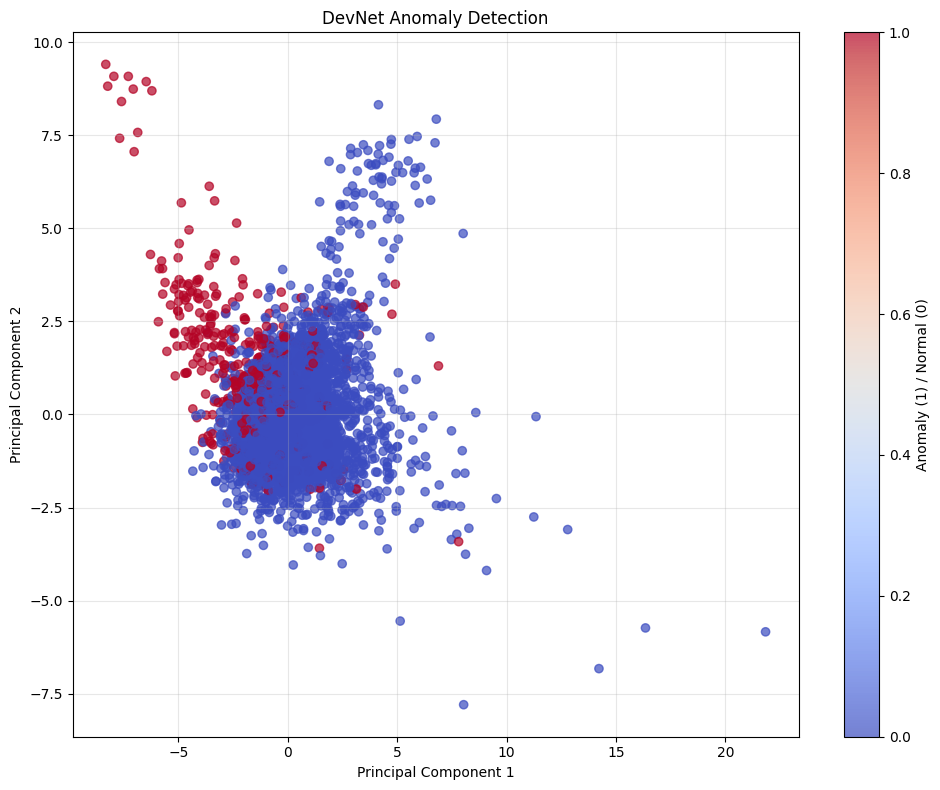

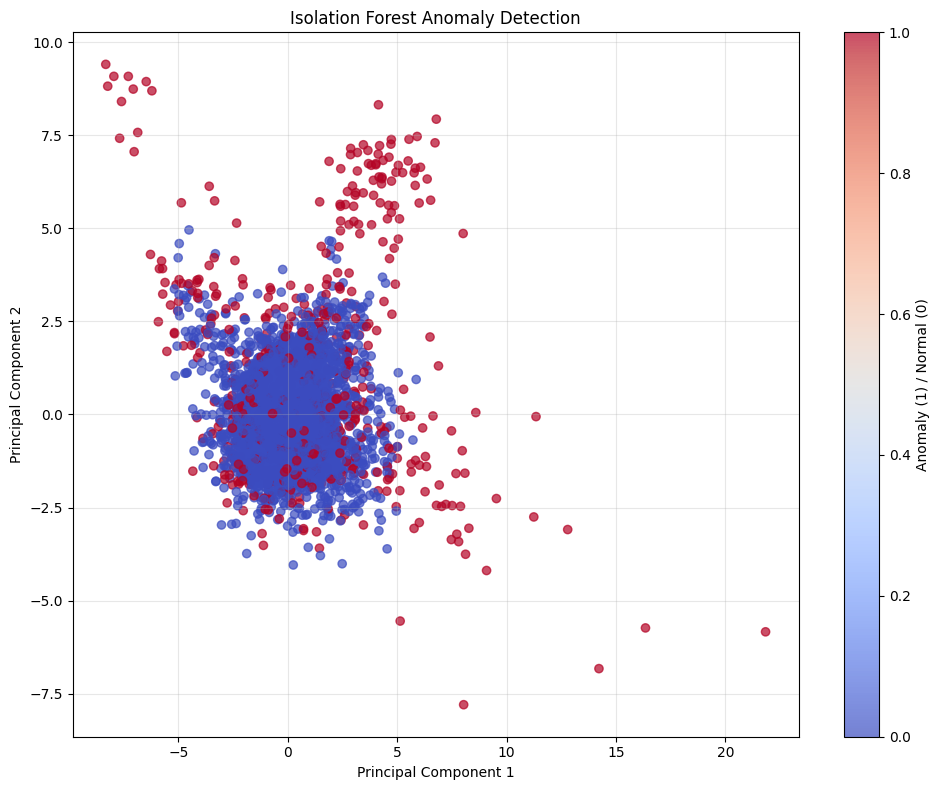

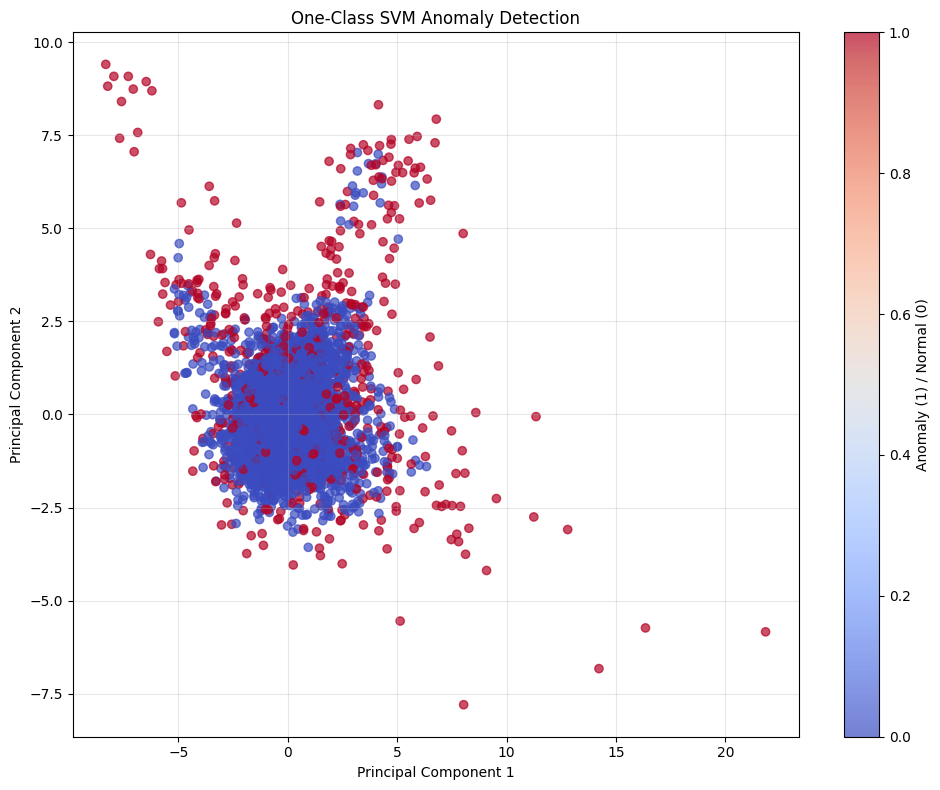

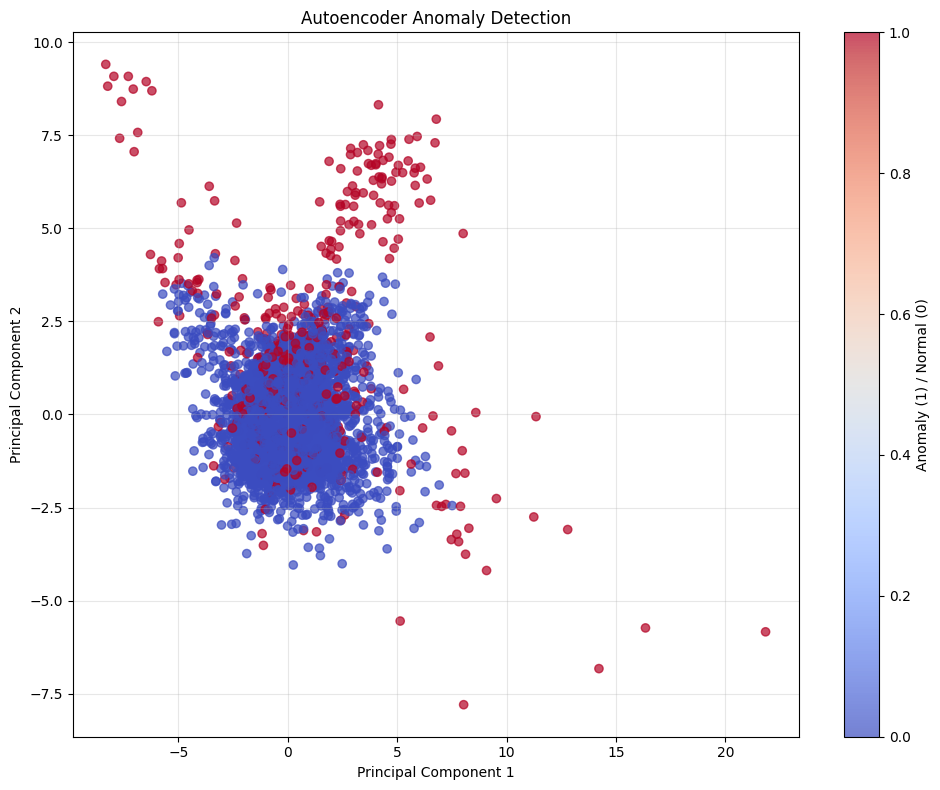

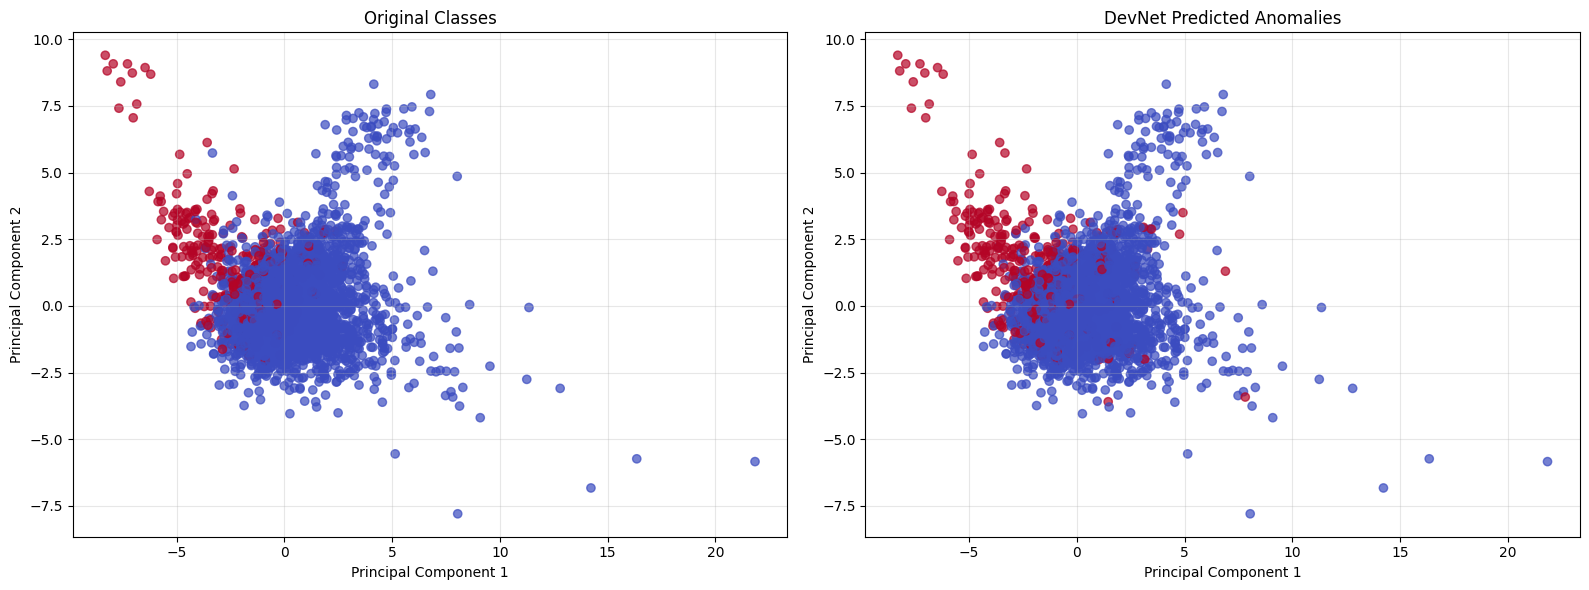

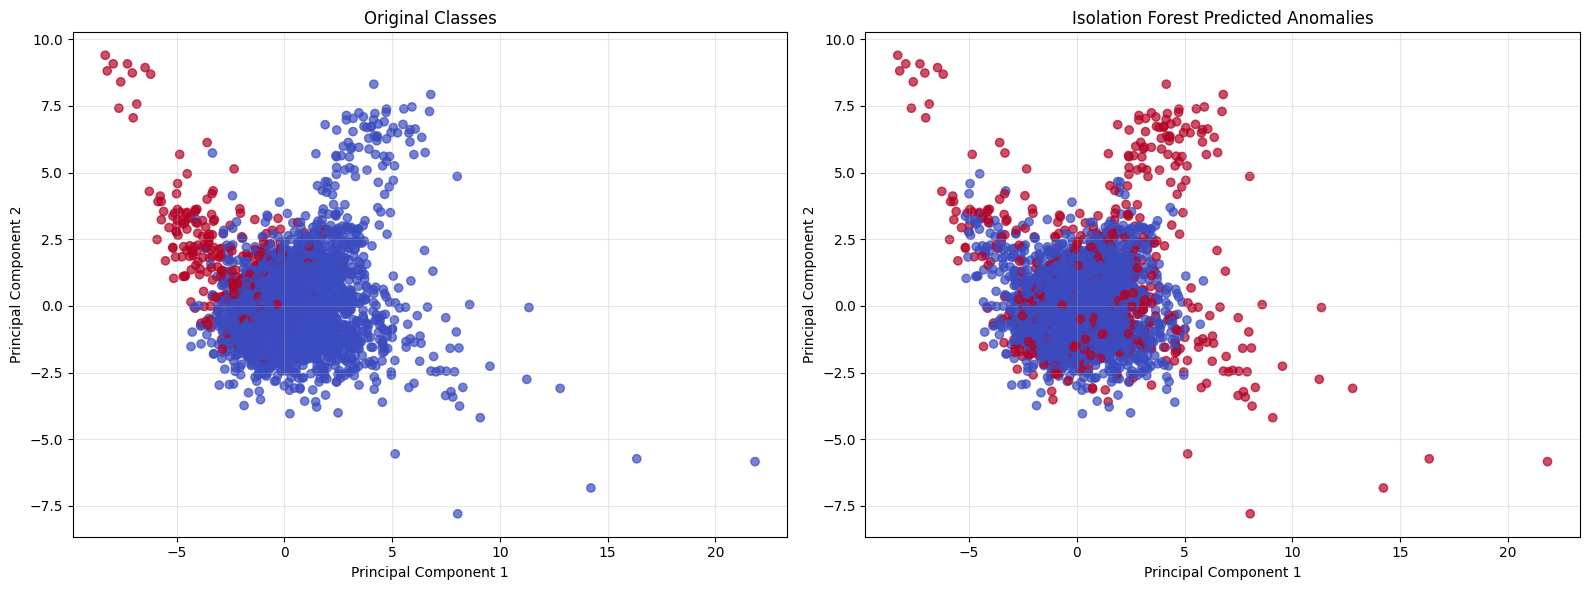

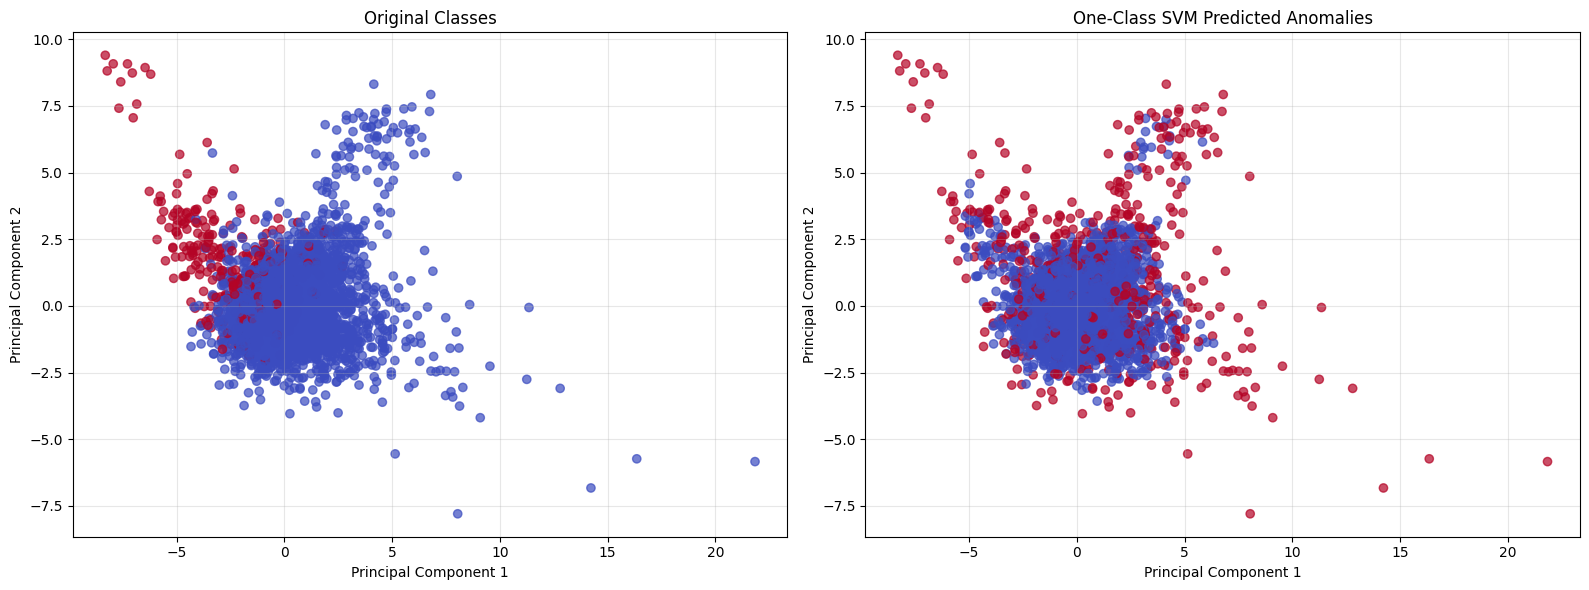

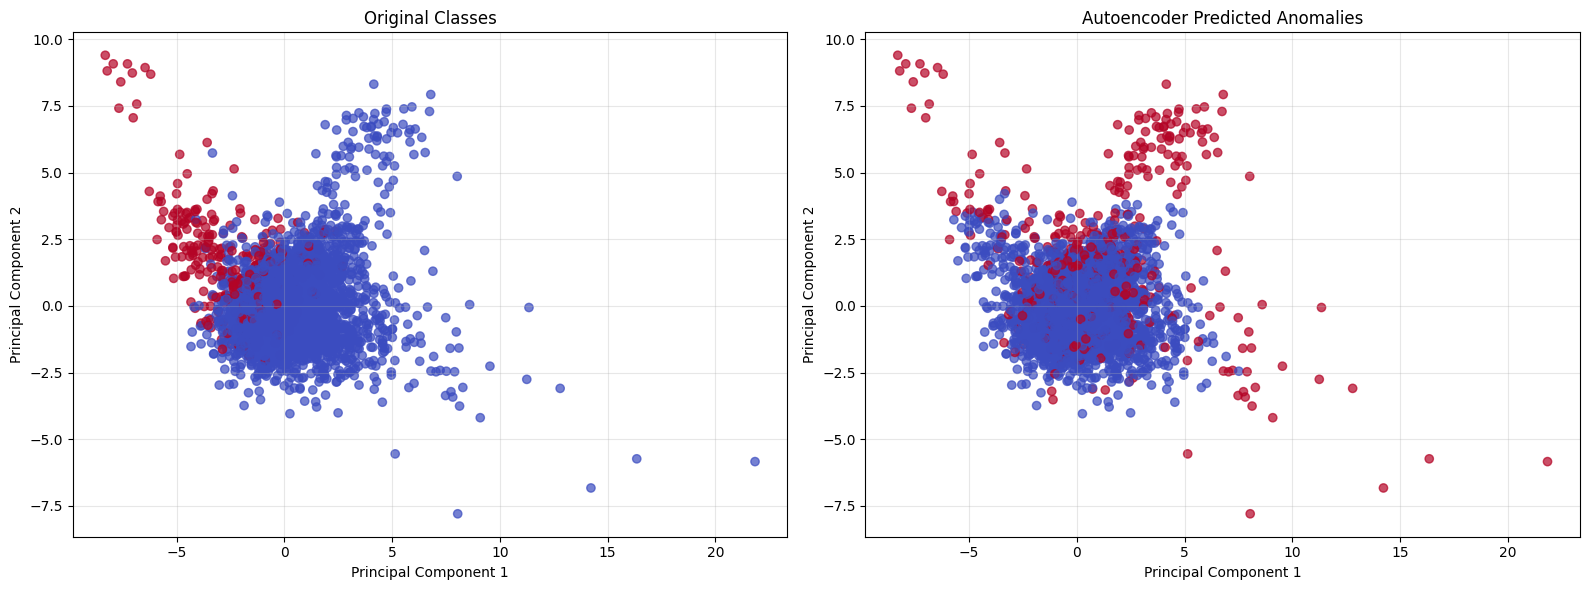

Feature importance not available for IsolationForest


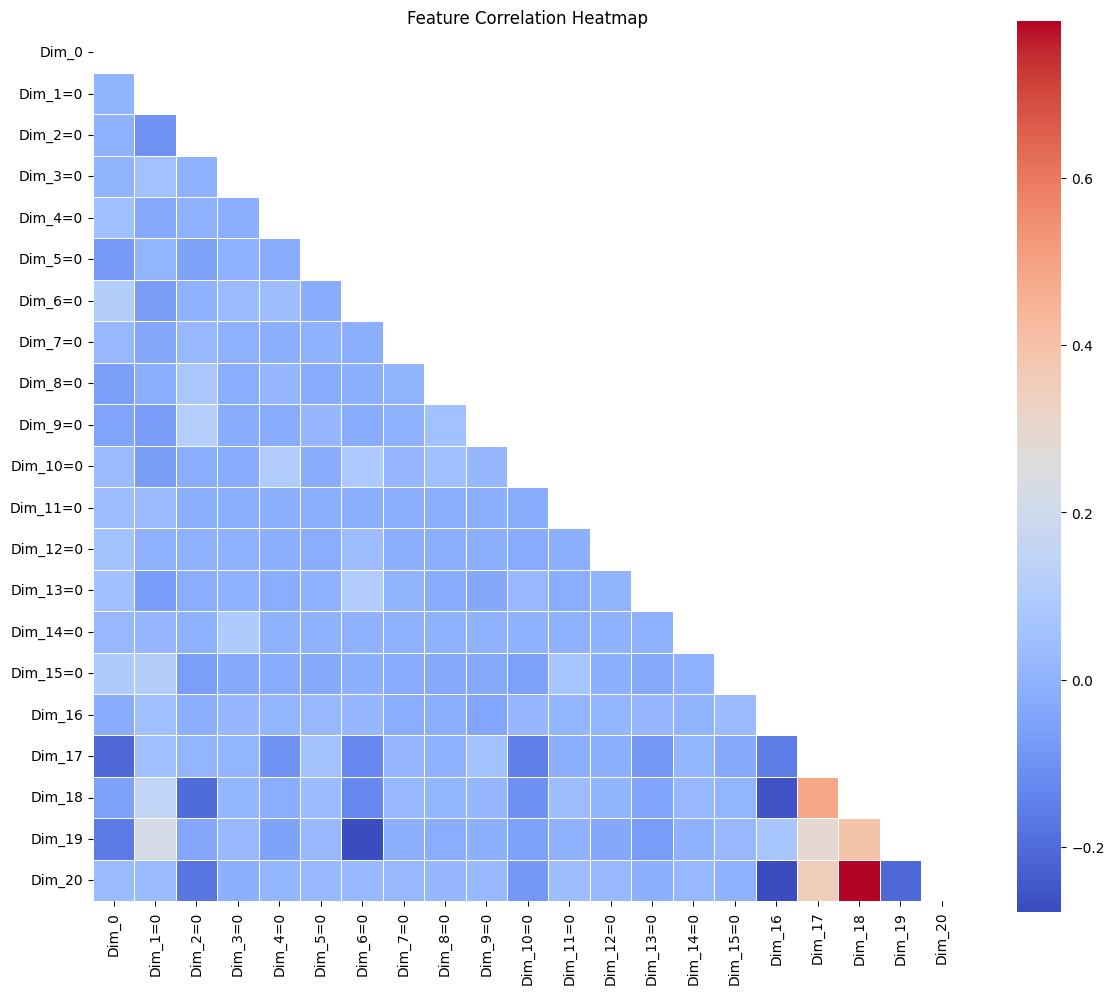


--- Comparison of Results ---
Number of anomalies detected:
DevNet: 720
Isolation Forest: 720
One-Class SVM: 726
Autoencoder: 720

Classification Report - DevNet:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      6666
           1       0.70      0.94      0.80       534

    accuracy                           0.97      7200
   macro avg       0.85      0.96      0.89      7200
weighted avg       0.97      0.97      0.97      7200


Classification Report - Isolation Forest:
              precision    recall  f1-score   support

           0       0.93      0.90      0.92      6666
           1       0.11      0.15      0.12       534

    accuracy                           0.85      7200
   macro avg       0.52      0.52      0.52      7200
weighted avg       0.87      0.85      0.86      7200


Classification Report - One-Class SVM:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import seaborn as sns
import os
from sklearn.model_selection import train_test_split

# Create directories to avoid FileNotFoundError
os.makedirs('./results', exist_ok=True)
os.makedirs('./model', exist_ok=True)

# Import DevNet functions
from devnet import deviation_network, batch_generator_sup, inject_noise, load_model_weight_predict

# Load data
df = pd.read_csv('/content/annthyroid_21feat_normalised.csv')

# Check if 'class' column exists
if 'class' not in df.columns:
    df.columns = [f'Dim_{i}' for i in range(len(df.columns)-1)] + ['class']

print(f"Data shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Class distribution: \n{df['class'].value_counts()}")

# Separate features and target
X = df.drop('class', axis=1)
y = df['class']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# DevNet Implementation
print("\n--- DevNet ---")
# Parameters matching devnet.py
network_depth = 2
known_outliers = 30
cont_rate = 0.02
batch_size = 512
nb_batch = 20
epochs = 50
random_seed = 42

# Train-test split for DevNet
x_train, x_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=random_seed, stratify=y
)

# Prepare training data
y_train = np.array(y_train)
outlier_indices = np.where(y_train == 1)[0]
inlier_indices = np.where(y_train == 0)[0]
n_outliers = len(outlier_indices)
print(f"Original training size: {x_train.shape[0]}, No. outliers: {n_outliers}")

# Remove excess outliers
rng = np.random.RandomState(random_seed)
if n_outliers > known_outliers:
    mn = n_outliers - known_outliers
    remove_idx = rng.choice(outlier_indices, mn, replace=False)
    x_train = np.delete(x_train, remove_idx, axis=0)
    y_train = np.delete(y_train, remove_idx, axis=0)

# Inject noise
outliers = x_train[y_train == 1]
n_noise = int(len(np.where(y_train == 0)[0]) * cont_rate / (1. - cont_rate))
noises = inject_noise(outliers, n_noise, random_seed)
x_train = np.append(x_train, noises, axis=0)
y_train = np.append(y_train, np.zeros((noises.shape[0],)))

# Update indices
outlier_indices = np.where(y_train == 1)[0]
inlier_indices = np.where(y_train == 0)[0]
print(f"Training data size: {x_train.shape[0]}, No. outliers: {len(outlier_indices)}")

# Train DevNet
input_shape = x_train.shape[1:]
model = deviation_network(input_shape, network_depth)
model_name = f"./model/devnet_temp.weights.h5"
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    model_name, monitor='loss', verbose=0, save_best_only=True, save_weights_only=True
)
model.fit(
    batch_generator_sup(x_train, outlier_indices, inlier_indices, batch_size, nb_batch, rng),
    steps_per_epoch=nb_batch,
    epochs=epochs,
    callbacks=[checkpointer],
    verbose=0
)

# Predict on full dataset
scores_devnet = load_model_weight_predict(model_name, input_shape, network_depth, X_scaled)
scores_devnet = scores_devnet.flatten()
threshold_devnet = np.percentile(scores_devnet, 90)
y_pred_devnet = np.where(scores_devnet > threshold_devnet, 1, 0)

# 1. Isolation Forest Implementation
print("\n--- Isolation Forest ---")
iforest = IsolationForest(contamination=0.1, random_state=42)
y_pred_if = iforest.fit_predict(X_scaled)
y_pred_if = np.where(y_pred_if == -1, 1, 0)
scores_if = -iforest.score_samples(X_scaled)

# 2. One-Class SVM Implementation
print("\n--- One-Class SVM ---")
ocsvm = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
y_pred_svm = ocsvm.fit_predict(X_scaled)
y_pred_svm = np.where(y_pred_svm == -1, 1, 0)
scores_svm = -ocsvm.decision_function(X_scaled)

# 3. Autoencoder Implementation
print("\n--- Autoencoder ---")
input_dim = X_scaled.shape[1]
encoding_dim = 10
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='sigmoid')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse')
history = autoencoder.fit(
    X_scaled, X_scaled,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_split=0.2,
    verbose=0
)
reconstructions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)
threshold = np.percentile(mse, 90)
y_pred_ae = np.where(mse > threshold, 1, 0)
scores_ae = mse

# Visualization 1: PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot functions
def plot_pca_results(X_pca, predictions, title):
    plt.figure(figsize=(10, 8))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predictions, cmap='coolwarm', alpha=0.7)
    plt.colorbar(label='Anomaly (1) / Normal (0)')
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plotting PCA results
plot_pca_results(X_pca, y_pred_devnet, 'DevNet Anomaly Detection')
plot_pca_results(X_pca, y_pred_if, 'Isolation Forest Anomaly Detection')
plot_pca_results(X_pca, y_pred_svm, 'One-Class SVM Anomaly Detection')
plot_pca_results(X_pca, y_pred_ae, 'Autoencoder Anomaly Detection')

# Visualization 2: Compare original class vs predicted anomalies
def plot_comparison_with_truth(X_pca, y_true, y_pred, algorithm):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=y_true, cmap='coolwarm', alpha=0.7)
    ax1.set_title('Original Classes')
    ax1.set_xlabel('Principal Component 1')
    ax1.set_ylabel('Principal Component 2')
    ax1.grid(True, alpha=0.3)
    ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, cmap='coolwarm', alpha=0.7)
    ax2.set_title(f'{algorithm} Predicted Anomalies')
    ax2.set_xlabel('Principal Component 1')
    ax2.set_ylabel('Principal Component 2')
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Compare each algorithm with ground truth
plot_comparison_with_truth(X_pca, y, y_pred_devnet, 'DevNet')
plot_comparison_with_truth(X_pca, y, y_pred_if, 'Isolation Forest')
plot_comparison_with_truth(X_pca, y, y_pred_svm, 'One-Class SVM')
plot_comparison_with_truth(X_pca, y, y_pred_ae, 'Autoencoder')

# Visualization 3: Feature importance for Isolation Forest
def plot_feature_importance(model, feature_names):
    importances = None
    try:
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        else:
            print(f"Feature importance not available for {model.__class__.__name__}")
            return
        plt.figure(figsize=(12, 6))
        indices = np.argsort(importances)[::-1]
        plt.title('Feature Importance for Anomaly Detection')
        plt.bar(range(len(importances)), importances[indices], align='center')
        plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
        plt.tight_layout()
        plt.show()
    except:
        print("Error in plotting feature importance")

# Plot feature importance (only for Isolation Forest)
plot_feature_importance(iforest, X.columns)


# Visualization 5: Correlation heatmap of features
plt.figure(figsize=(12, 10))
corr = X.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=False, square=True, linewidths=.5)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

# Compare results
print("\n--- Comparison of Results ---")
print("Number of anomalies detected:")
print(f"DevNet: {sum(y_pred_devnet)}")
print(f"Isolation Forest: {sum(y_pred_if)}")
print(f"One-Class SVM: {sum(y_pred_svm)}")
print(f"Autoencoder: {sum(y_pred_ae)}")

# Classification reports
print("\nClassification Report - DevNet:")
try:
    print(classification_report(y, y_pred_devnet))
except:
    print("Could not generate classification report, labels might not be in the right format")

print("\nClassification Report - Isolation Forest:")
try:
    print(classification_report(y, y_pred_if))
except:
    print("Could not generate classification report, labels might not be in the right format")

print("\nClassification Report - One-Class SVM:")
try:
    print(classification_report(y, y_pred_svm))
except:
    print("Could not generate classification report, labels might not be in the right format")

print("\nClassification Report - Autoencoder:")
try:
    print(classification_report(y, y_pred_ae))
except:
    print("Could not generate classification report, labels might not be in the right format")

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.manifold import TSNE
# from sklearn.decomposition import PCA
# import seaborn as sns
# from sklearn.metrics import roc_curve, precision_recall_curve, auc
# import pandas as pd

# def plot_score_distributions(scores, y_test, title="Score Distribution", save_path=None):
#     """
#     Plot the distribution of anomaly scores for normal and anomalous points.

#     Parameters:
#     -----------
#     scores : numpy.ndarray
#         Anomaly scores predicted by the model
#     y_test : numpy.ndarray
#         Ground truth labels (0 for normal, 1 for anomalous)
#     title : str
#         Plot title
#     save_path : str, optional
#         Path to save the figure
#     """
#     plt.figure(figsize=(10, 6))

#     # Get scores for normal and anomalous points
#     normal_scores = scores[y_test == 0].flatten()
#     anomaly_scores = scores[y_test == 1].flatten()

#     # Plot the distributions
#     sns.histplot(normal_scores, color='blue', label='Normal', kde=True, stat='density', alpha=0.6)
#     sns.histplot(anomaly_scores, color='red', label='Anomalous', kde=True, stat='density', alpha=0.6)

#     plt.title(title, fontsize=15)
#     plt.xlabel('Anomaly Score', fontsize=12)
#     plt.ylabel('Density', fontsize=12)
#     plt.legend(fontsize=12)
#     plt.grid(True, linestyle='--', alpha=0.7)

#     if save_path:
#         plt.savefig(save_path, dpi=300, bbox_inches='tight')
#     plt.show()

# def plot_roc_pr_curves(scores, y_test, title_prefix="Model Performance", save_path=None):
#     """
#     Plot ROC and Precision-Recall curves.

#     Parameters:
#     -----------
#     scores : numpy.ndarray
#         Anomaly scores predicted by the model
#     y_test : numpy.ndarray
#         Ground truth labels (0 for normal, 1 for anomalous)
#     title_prefix : str
#         Prefix for plot titles
#     save_path : str, optional
#         Path to save the figure
#     """
#     # Prepare data
#     scores = scores.flatten()
#     y_test = y_test.flatten()

#     # Calculate ROC curve
#     fpr, tpr, _ = roc_curve(y_test, scores)
#     roc_auc = auc(fpr, tpr)

#     # Calculate Precision-Recall curve
#     precision, recall, _ = precision_recall_curve(y_test, scores)
#     pr_auc = auc(recall, precision)

#     # Create subplots
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

#     # Plot ROC curve
#     ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
#     ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#     ax1.set_xlim([0.0, 1.0])
#     ax1.set_ylim([0.0, 1.05])
#     ax1.set_xlabel('False Positive Rate', fontsize=12)
#     ax1.set_ylabel('True Positive Rate', fontsize=12)
#     ax1.set_title(f'{title_prefix} - ROC Curve', fontsize=15)
#     ax1.legend(loc="lower right", fontsize=12)
#     ax1.grid(True, linestyle='--', alpha=0.7)

#     # Plot Precision-Recall curve
#     ax2.plot(recall, precision, color='green', lw=2, label=f'AUC = {pr_auc:.4f}')
#     ax2.set_xlim([0.0, 1.0])
#     ax2.set_ylim([0.0, 1.05])
#     ax2.set_xlabel('Recall', fontsize=12)
#     ax2.set_ylabel('Precision', fontsize=12)
#     ax2.set_title(f'{title_prefix} - Precision-Recall Curve', fontsize=15)
#     ax2.legend(loc="lower left", fontsize=12)
#     ax2.grid(True, linestyle='--', alpha=0.7)

#     plt.tight_layout()

#     if save_path:
#         plt.savefig(save_path, dpi=300, bbox_inches='tight')
#     plt.show()

#     return roc_auc, pr_auc

# def visualize_data_with_scores(X_test, y_test, scores, method='tsne', title_prefix="Data Visualization", save_path=None):
#     """
#     Visualize high-dimensional data in 2D with color coding based on
#     (1) true labels and (2) anomaly scores.

#     Parameters:
#     -----------
#     X_test : numpy.ndarray
#         Test data features
#     y_test : numpy.ndarray
#         Ground truth labels (0 for normal, 1 for anomalous)
#     scores : numpy.ndarray
#         Anomaly scores predicted by the model
#     method : str
#         Dimensionality reduction method ('tsne' or 'pca')
#     title_prefix : str
#         Prefix for plot titles
#     save_path : str, optional
#         Path to save the figure
#     """
#     # Convert sparse matrix to dense if needed
#     if hasattr(X_test, 'toarray'):
#         X_test = X_test.toarray()

#     # Apply dimensionality reduction
#     if method == 'tsne':
#         reducer = TSNE(n_components=2, random_state=42)
#         title_method = 't-SNE'
#     else:  # pca
#         reducer = PCA(n_components=2, random_state=42)
#         title_method = 'PCA'

#     # Reduce dimensionality
#     X_embedded = reducer.fit_transform(X_test)

#     # Create subplots
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

#     # Plot based on true labels
#     scatter1 = ax1.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_test, cmap='coolwarm',
#                            alpha=0.7, edgecolors='w', linewidth=0.5)
#     ax1.set_title(f'{title_prefix} - True Labels ({title_method})', fontsize=15)
#     ax1.set_xlabel(f'{title_method} Dimension 1', fontsize=12)
#     ax1.set_ylabel(f'{title_method} Dimension 2', fontsize=12)
#     legend1 = ax1.legend(*scatter1.legend_elements(), title="Classes", loc="upper right")
#     ax1.add_artist(legend1)
#     ax1.grid(True, linestyle='--', alpha=0.7)

#     # Plot based on anomaly scores
#     scatter2 = ax2.scatter(X_embedded[:, 0], X_embedded[:, 1], c=scores.flatten(), cmap='viridis',
#                            alpha=0.7, edgecolors='w', linewidth=0.5)
#     ax2.set_title(f'{title_prefix} - Anomaly Scores ({title_method})', fontsize=15)
#     ax2.set_xlabel(f'{title_method} Dimension 1', fontsize=12)
#     ax2.set_ylabel(f'{title_method} Dimension 2', fontsize=12)
#     cbar = plt.colorbar(scatter2, ax=ax2)
#     cbar.set_label('Anomaly Score', fontsize=12)
#     ax2.grid(True, linestyle='--', alpha=0.7)

#     plt.tight_layout()

#     if save_path:
#         plt.savefig(save_path, dpi=300, bbox_inches='tight')
#     plt.show()

# def plot_training_history(history, title="Training History", save_path=None):
#     """
#     Plot the training history (loss curve).

#     Parameters:
#     -----------
#     history : keras.callbacks.History
#         Training history object
#     title : str
#         Plot title
#     save_path : str, optional
#         Path to save the figure
#     """
#     plt.figure(figsize=(10, 6))
#     plt.plot(history.history['loss'], color='blue', label='Loss')

#     plt.title(title, fontsize=15)
#     plt.xlabel('Epoch', fontsize=12)
#     plt.ylabel('Loss', fontsize=12)
#     plt.legend(fontsize=12)
#     plt.grid(True, linestyle='--', alpha=0.7)

#     if save_path:
#         plt.savefig(save_path, dpi=300, bbox_inches='tight')
#     plt.show()

# def plot_performance_by_contamination(contam_rates, auc_roc_means, auc_pr_means,
#                                       auc_roc_stds=None, auc_pr_stds=None,
#                                       title="Performance vs. Contamination Rate", save_path=None):
#     """
#     Plot performance metrics against contamination rates.

#     Parameters:
#     -----------
#     contam_rates : list
#         List of contamination rates
#     auc_roc_means : list
#         List of mean AUC-ROC values
#     auc_pr_means : list
#         List of mean AUC-PR values
#     auc_roc_stds : list, optional
#         List of AUC-ROC standard deviations
#     auc_pr_stds : list, optional
#         List of AUC-PR standard deviations
#     title : str
#         Plot title
#     save_path : str, optional
#         Path to save the figure
#     """
#     plt.figure(figsize=(10, 6))

#     if auc_roc_stds is not None:
#         plt.errorbar(contam_rates, auc_roc_means, yerr=auc_roc_stds, fmt='-o', color='blue',
#                     capsize=5, label='AUC-ROC')
#     else:
#         plt.plot(contam_rates, auc_roc_means, '-o', color='blue', label='AUC-ROC')

#     if auc_pr_stds is not None:
#         plt.errorbar(contam_rates, auc_pr_means, yerr=auc_pr_stds, fmt='-s', color='green',
#                     capsize=5, label='AUC-PR')
#     else:
#         plt.plot(contam_rates, auc_pr_means, '-s', color='green', label='AUC-PR')

#     plt.title(title, fontsize=15)
#     plt.xlabel('Contamination Rate', fontsize=12)
#     plt.ylabel('AUC', fontsize=12)
#     plt.legend(fontsize=12)
#     plt.grid(True, linestyle='--', alpha=0.7)
#     plt.ylim([0, 1.05])

#     if save_path:
#         plt.savefig(save_path, dpi=300, bbox_inches='tight')
#     plt.show()

# def plot_performance_by_known_outliers(known_outliers_counts, auc_roc_means, auc_pr_means,
#                                        auc_roc_stds=None, auc_pr_stds=None,
#                                        title="Performance vs. Number of Known Outliers", save_path=None):
#     """
#     Plot performance metrics against number of known outliers.

#     Parameters:
#     -----------
#     known_outliers_counts : list
#         List of known outliers counts
#     auc_roc_means : list
#         List of mean AUC-ROC values
#     auc_pr_means : list
#         List of mean AUC-PR values
#     auc_roc_stds : list, optional
#         List of AUC-ROC standard deviations
#     auc_pr_stds : list, optional
#         List of AUC-PR standard deviations
#     title : str
#         Plot title
#     save_path : str, optional
#         Path to save the figure
#     """
#     plt.figure(figsize=(10, 6))

#     if auc_roc_stds is not None:
#         plt.errorbar(known_outliers_counts, auc_roc_means, yerr=auc_roc_stds, fmt='-o', color='blue',
#                     capsize=5, label='AUC-ROC')
#     else:
#         plt.plot(known_outliers_counts, auc_roc_means, '-o', color='blue', label='AUC-ROC')

#     if auc_pr_stds is not None:
#         plt.errorbar(known_outliers_counts, auc_pr_means, yerr=auc_pr_stds, fmt='-s', color='green',
#                     capsize=5, label='AUC-PR')
#     else:
#         plt.plot(known_outliers_counts, auc_pr_means, '-s', color='green', label='AUC-PR')

#     plt.title(title, fontsize=15)
#     plt.xlabel('Number of Known Outliers', fontsize=12)
#     plt.ylabel('AUC', fontsize=12)
#     plt.legend(fontsize=12)
#     plt.grid(True, linestyle='--', alpha=0.7)
#     plt.ylim([0, 1.05])

#     if save_path:
#         plt.savefig(save_path, dpi=300, bbox_inches='tight')
#     plt.show()

# def plot_results_summary(results_df, metric='auc_roc', by='dataset', title=None, save_path=None):
#     """
#     Plot a summary of results, comparing performance across datasets or model configurations.

#     Parameters:
#     -----------
#     results_df : pandas.DataFrame
#         DataFrame with results
#     metric : str
#         Metric to plot ('auc_roc' or 'auc_pr')
#     by : str
#         Factor to group by ('dataset', 'network_depth', 'cont_rate', or 'known_outliers')
#     title : str, optional
#         Plot title
#     save_path : str, optional
#         Path to save the figure
#     """
#     plt.figure(figsize=(12, 7))

#     if metric == 'auc_roc':
#         y_col = 'mean_auc'
#         err_col = 'std_auc'
#         y_label = 'AUC-ROC'
#     else:  # 'auc_pr'
#         y_col = 'mean_aucpr'
#         err_col = 'std_aucpr'
#         y_label = 'AUC-PR'

#     # Group by the specified factor
#     grouped = results_df.groupby(by)

#     # For each group, plot a bar with error bars
#     names = []
#     values = []
#     errors = []

#     for name, group in grouped:
#         names.append(str(name))
#         values.append(group[y_col].values[0])
#         errors.append(group[err_col].values[0])

#     # Create bar plot with error bars
#     x_pos = np.arange(len(names))
#     plt.bar(x_pos, values, yerr=errors, align='center', alpha=0.7, capsize=10, color='skyblue', edgecolor='black')

#     plt.xticks(x_pos, names, rotation=45 if by == 'dataset' else 0)
#     plt.ylabel(y_label, fontsize=12)
#     plt.xlabel(by.replace('_', ' ').title(), fontsize=12)

#     if title:
#         plt.title(title, fontsize=15)
#     else:
#         plt.title(f'{y_label} by {by.replace("_", " ").title()}', fontsize=15)

#     plt.ylim([0, 1.05])
#     plt.grid(True, linestyle='--', alpha=0.7, axis='y')
#     plt.tight_layout()

#     if save_path:
#         plt.savefig(save_path, dpi=300, bbox_inches='tight')
#     plt.show()